In [ ]:
from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns

In [ ]:
start_date = dt.datetime.now() - dt.timedelta(days=365 * 50)
end_date = dt.datetime.now()

df = yf.download("AMAT", start=start_date, end=end_date)

df.reset_index(inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['50_day_ma'] = df['Close'].rolling(window=50).mean()
df['1000_day_ma'] = df['Close'].rolling(window=1000).mean()
df['10_day_vol_avg'] = df['Volume'].rolling(window=10).mean()
df['200_day_vol_avg'] = df['Volume'].rolling(window=200).mean()

#TODO: make function to shift closing price 50 days in the future

df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']]

df.to_csv('AMAToutput.csv', index=False)

print(df)

[*********************100%%**********************]  1 of 1 completed
            Date        Open        High         Low       Close    Volume  \
0     1980-03-17    0.000000    0.098090    0.095486    0.095486   3600000   
1     1980-03-18    0.000000    0.096354    0.093750    0.093750   3715200   
2     1980-03-19    0.000000    0.098090    0.095486    0.095486   2016000   
3     1980-03-20    0.000000    0.099826    0.097222    0.097222   3657600   
4     1980-03-21    0.000000    0.103299    0.100694    0.100694   3024000   
...          ...         ...         ...         ...         ...       ...   
10944 2023-08-14  138.199997  141.940002  137.669998  141.889999   4850400   
10945 2023-08-15  141.270004  141.850006  139.740005  140.080002   3384900   
10946 2023-08-16  140.529999  141.259995  138.169998  138.250000   4613000   
10947 2023-08-17  139.190002  139.789993  136.570007  137.589996   7065700   
10948 2023-08-18  137.330002  143.649994  135.529999  142.660004  1153630

In [ ]:
#dfm = df.loc[1000:,:]
#dfm = dfm.sample(100)

In [ ]:
#corr = dfm.corr()
#corr.style.background_gradient(cmap='coolwarm').format(precision=2)

In [ ]:
#sns.lmplot(data=dfm, x='50_day_ma', y='1000_day_ma')

In [ ]:
#plt.plot_date(dfm['Date'], dfm['Open'])

In [ ]:
df.set_index('Date', inplace=True)

df.dropna(inplace=True)

column_to_shift = df['Close']

# Perform the shift (7 indexes down)
shifted_column = np.concatenate((column_to_shift[7:], np.zeros(7)))

# Replace the original column with the shifted one
df['Close Shifted'] = shifted_column

df = df.drop(df.index[0:2000])

train_df = df.sort_values(by=['Date']).copy()

#FEATURES = ['Close', '50_day_ma', '200_day_ma']
FEATURES = ['Open', 'High', 'Low', 'Close', 'Close Shifted', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']

print('FEATURE LIST')
print([f for f in FEATURES])

print(df)

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close Shifted']

data_filtered_ext.tail()

nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close Shifted'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Close Shifted', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']
                  Open        High         Low       Close    Volume  \
Date                                                                   
1992-01-27    0.593750    0.597656    0.582031    0.589844   6912000   
1992-01-28    0.597656    0.605469    0.593750    0.597656  10969600   
1992-01-29    0.593750    0.628906    0.593750    0.609375  17113600   
1992-01-30    0.609375    0.625000    0.582031    0.597656  16531200   
1992-01-31    0.597656    0.607422    0.593750    0.599609   4000000   
...                ...         ...         ...         ...       ...   
2023-08-14  138.199997  141.940002  137.669998  141.889999   4850400   
2023-08-15  141.270004  141.850006  139.740005  140.080002   3384900   
2023-08-16  140.529999  141.259995  138.169998  138.250000   4613000   
2023-08-17  139.190002  139.789993  136.570007  137.589996   7065700  

<ipython-input-7-7ce59c3cf9fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-7-7ce59c3cf9fa>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close Shifted'] = shifted_column


In [ ]:
sequence_length = 200

index_Close = data_filtered.columns.get_loc("Close Shifted")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

In [ ]:
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    print(index_Close)
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close])

    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

x_train = np.delete(x_train, 4, axis=2)
x_test = np.delete(x_test, 4, axis=2)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

4
4
(6955, 200, 9) (6955,)
(795, 200, 9) (795,)
0.22460480201295677
0.006549401197604791
1800 200 9


In [ ]:
model.compile(optimizer='adam', loss='mse')

epochs = 30
batch_size = 32
early_stop = EarlyStopping(monitor='loss', patience = 3, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[])

Epoch 1/30
218/218 [==============================] - 155s 667ms/step - loss: 0.0272 - val_loss: 0.0098
Epoch 2/30
218/218 [==============================] - 151s 692ms/step - loss: 1.5717e-04 - val_loss: 0.0108
Epoch 3/30
218/218 [==============================] - 151s 691ms/step - loss: 1.5413e-04 - val_loss: 0.0094
Epoch 4/30
218/218 [==============================] - 150s 689ms/step - loss: 1.4989e-04 - val_loss: 0.0112
Epoch 5/30
218/218 [==============================] - 150s 690ms/step - loss: 1.5430e-04 - val_loss: 0.0092
Epoch 6/30
218/218 [==============================] - 150s 690ms/step - loss: 1.4967e-04 - val_loss: 0.0092
Epoch 7/30
218/218 [==============================] - 151s 691ms/step - loss: 1.3519e-04 - val_loss: 0.0104
Epoch 8/30
218/218 [==============================] - 151s 692ms/step - loss: 1.3671e-04 - val_loss: 0.0093
Epoch 9/30
218/218 [==============================] - 151s 692ms/step - loss: 1.2941e-04 - val_loss: 0.0134
Epoch 10/30
218/218 [===========

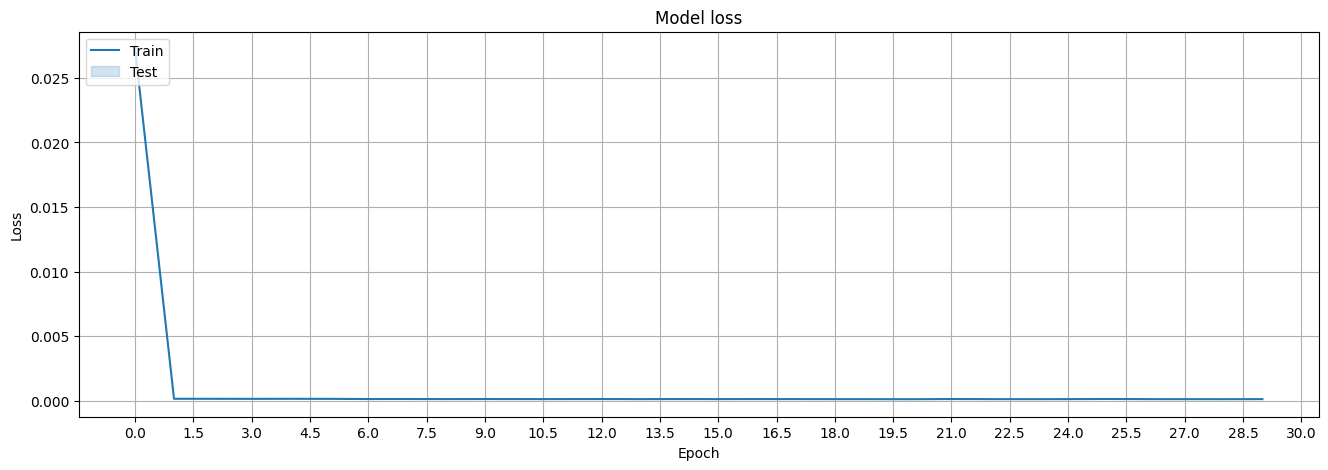

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

25/25 [==============================] - 6s 231ms/step
Accuracy: 0.482 %
Precision: 0.498 %
Recall: 0.505 %
F Score: 0.501 %


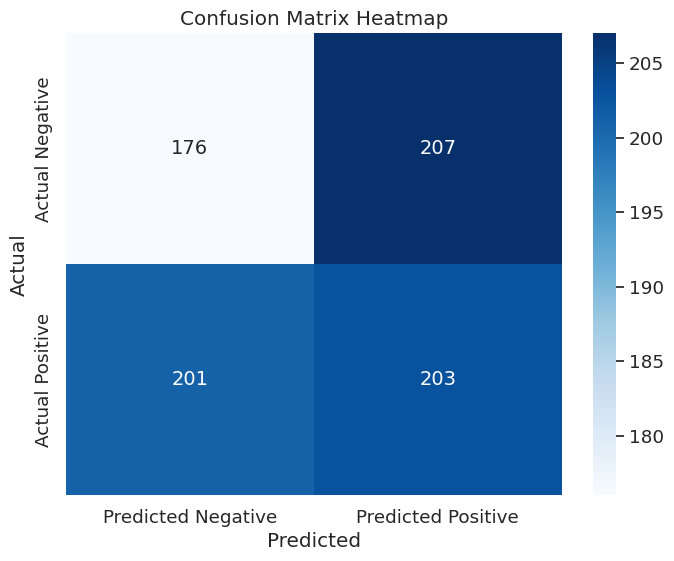

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

y_pred_bin = []
y_test_bin = []

for i in range(1, len(y_pred)-7):
    if (y_pred[i] > y_pred[i-1]):
      y_pred_bin.append(1)
    else:
      y_pred_bin.append(-1)

for i in range(1, len(y_test_unscaled)-7):
    if (y_test_unscaled[i] > y_test_unscaled[i-1]):
      y_test_bin.append(1)
    else:
      y_test_bin.append(-1)

count_up = 0
count_down = 0
total_up = 0
total_down = 0
for i in range(len(y_pred_bin)-7):
  if (y_pred_bin[i] == y_test_bin[i]):
    if (y_pred_bin[i] == 1):
      count_up += 1
    else:
      count_down += 1
  if (y_test_bin[i] == 1):
    total_up += 1
  else:
    total_down += 1

accuracy = (count_up + count_down)/(total_up + total_down)
precision = count_up/(count_up + total_down - count_down)
recall = count_up/(total_up)
f_score = 2 * (precision*recall)/(precision + recall)

print(f'Accuracy: {np.round(accuracy, 3)} %')
print(f'Precision: {np.round(precision, 3)} %')
print(f'Recall: {np.round(recall, 3)} %')
print(f'F Score: {np.round(f_score, 3)} %')

cm = confusion_matrix(y_test_bin, y_pred_bin)

# Create a heatmap of the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14}, cbar=True,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

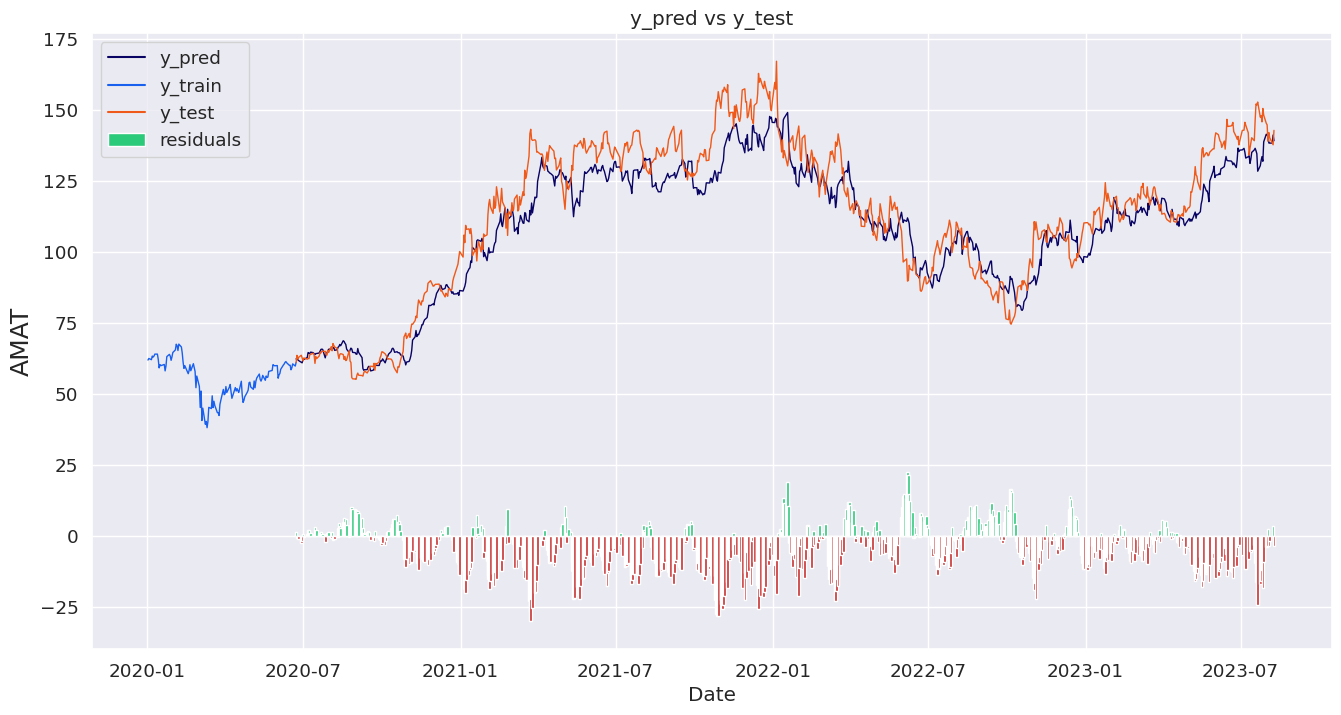

In [ ]:
display_start_date = "2020-01-01"

train = pd.DataFrame(data_filtered_ext['Close Shifted'][:train_data_len + 1]).rename(columns={'Close Shifted': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close Shifted'][train_data_len:][:-7]).rename(columns={'Close Shifted': 'y_test'})
valid.insert(1, "y_pred", y_pred[:-7], True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("AMAT", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length-7:-7]
new_df_exclude = df_temp.filter(FEATURES)
new_df_include = df_temp.filter(FEATURES)

#new_df_exclude = new_df_exclude.drop(new_df_exclude.columns[4], axis=1)

N = sequence_length

last_N_days = new_df_exclude[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

X_test_new = []
X_test_new.append(last_N_days_scaled)

pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

price_today = np.round(new_df_include['Close Shifted'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''

print(f'The close price for {"AMAT"} at {str(dt.date.today())} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')


1/1 [==============================] - 1s 715ms/step
The close price for AMAT at 2023-08-20 was 142.66
The predicted close price is 102.55000305175781 (-39.11%)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)
x_test = x_test[:-7]

# Make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverse transform predictions
train_predict = scaler_pred.inverse_transform(train_predict)
y_train = scaler_pred.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler_pred.inverse_transform(test_predict)
y_test = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test = y_test[:-7]

# Calculate metrics
mae_train = mean_absolute_error(y_train, train_predict)
mse_train = mean_squared_error(y_train, train_predict)
rmse_train = np.sqrt(mse_train)

mae_test = mean_absolute_error(y_test, y_pred[:-7])
mse_test = mean_squared_error(y_test, y_pred[:-7])
rmse_test = np.sqrt(mse_test)

print(f'Training MAE: {mae_train:.4f}')
print(f'Training MSE: {mse_train:.4f}')
print(f'Training RMSE: {rmse_train:.4f}')
print(f'Testing MAE: {mae_test:.4f}')
print(f'Testing MSE: {mse_test:.4f}')
print(f'Testing RMSE: {rmse_test:.4f}')

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(y_test, y_pred[:-7])
print(f'Mean Absolute Percentage Error: {mape:.4f}')

r2 = r2_score(y_test, y_pred[:-7])
print(f"R-squared (R2): {r2:.4f}")

4
4
25/25 [==============================] - 6s 240ms/step
Training MAE: 14.4421
Training MSE: 357.5200
Training RMSE: 18.9082
Testing MAE: 7.5595
Testing MSE: 91.0801
Testing RMSE: 9.5436
Mean Absolute Percentage Error: 6.5309
R-squared (R2): 0.8730


DatetimeIndex(['1992-01-27', '1992-01-28', '1992-01-29', '1992-01-30',
               '1992-01-31', '1992-02-03', '1992-02-04', '1992-02-05',
               '1992-02-06', '1992-02-07',
               ...
               '2023-07-27', '2023-07-28', '2023-07-31', '2023-08-01',
               '2023-08-02', '2023-08-03', '2023-08-04', '2023-08-07',
               '2023-08-08', '2023-08-09'],
              dtype='datetime64[ns]', name='Date', length=7944, freq=None)


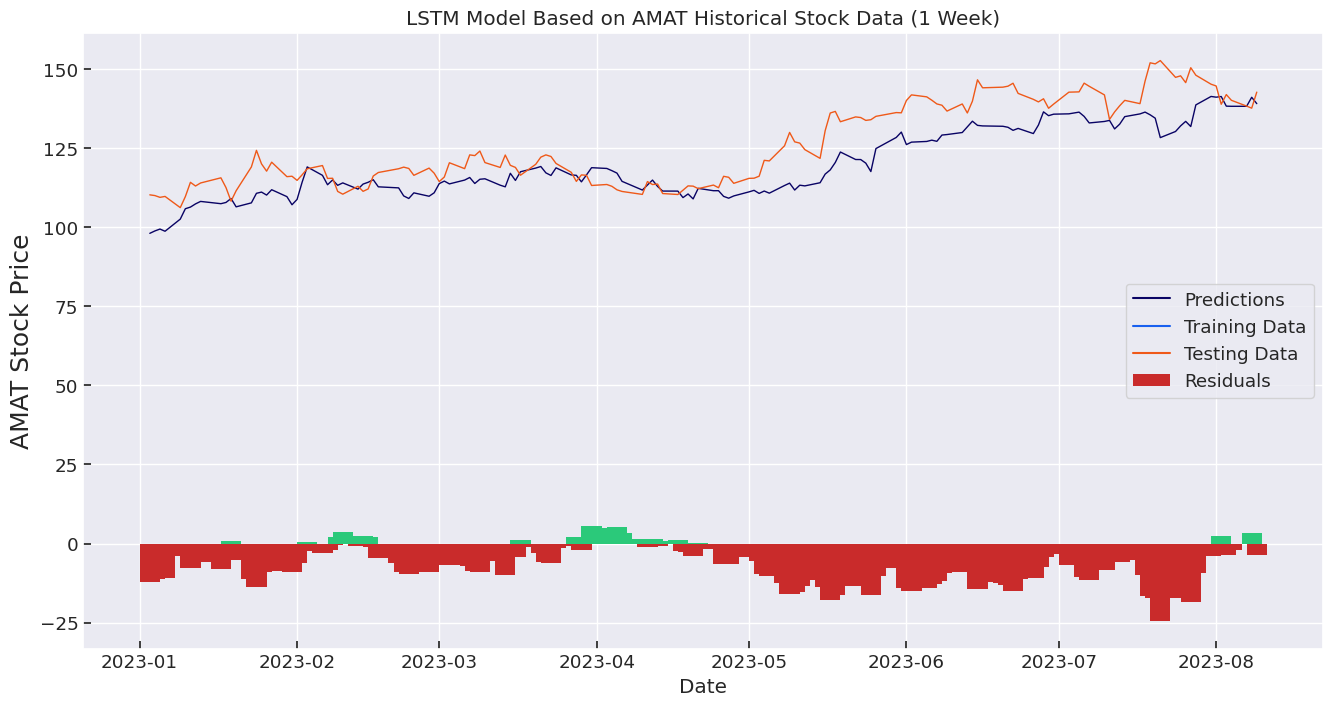

In [27]:
display_start_date = "2023-01-01"

train = pd.DataFrame(data_filtered_ext['Close Shifted'][:train_data_len + 1]).rename(columns={'Close Shifted': 'Training Data'})
valid = pd.DataFrame(data_filtered_ext['Close Shifted'][train_data_len:][:-7]).rename(columns={'Close Shifted': 'Testing Data'})
valid.insert(1, "Predictions", y_pred[:-7], True)
valid.insert(1, "Residuals", valid["Predictions"] - valid["Testing Data"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Model Based on AMAT Historical Stock Data (1 Week)")
plt.ylabel("AMAT Stock Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['Predictions', 'Training Data', 'Testing Data']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["Residuals"].dropna()]
ax1.bar(height=df_union_zoom['Residuals'].dropna(), x=df_union_zoom['Residuals'].dropna().index, width=4, label='Residuals', color=df_sub, edgecolor='none')
ax1.tick_params(which='both', direction='in', bottom=True, left=True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
plt.legend()
plt.show()

DatetimeIndex(['1992-01-27', '1992-01-28', '1992-01-29', '1992-01-30',
               '1992-01-31', '1992-02-03', '1992-02-04', '1992-02-05',
               '1992-02-06', '1992-02-07',
               ...
               '2023-07-27', '2023-07-28', '2023-07-31', '2023-08-01',
               '2023-08-02', '2023-08-03', '2023-08-04', '2023-08-07',
               '2023-08-08', '2023-08-09'],
              dtype='datetime64[ns]', name='Date', length=7944, freq=None)


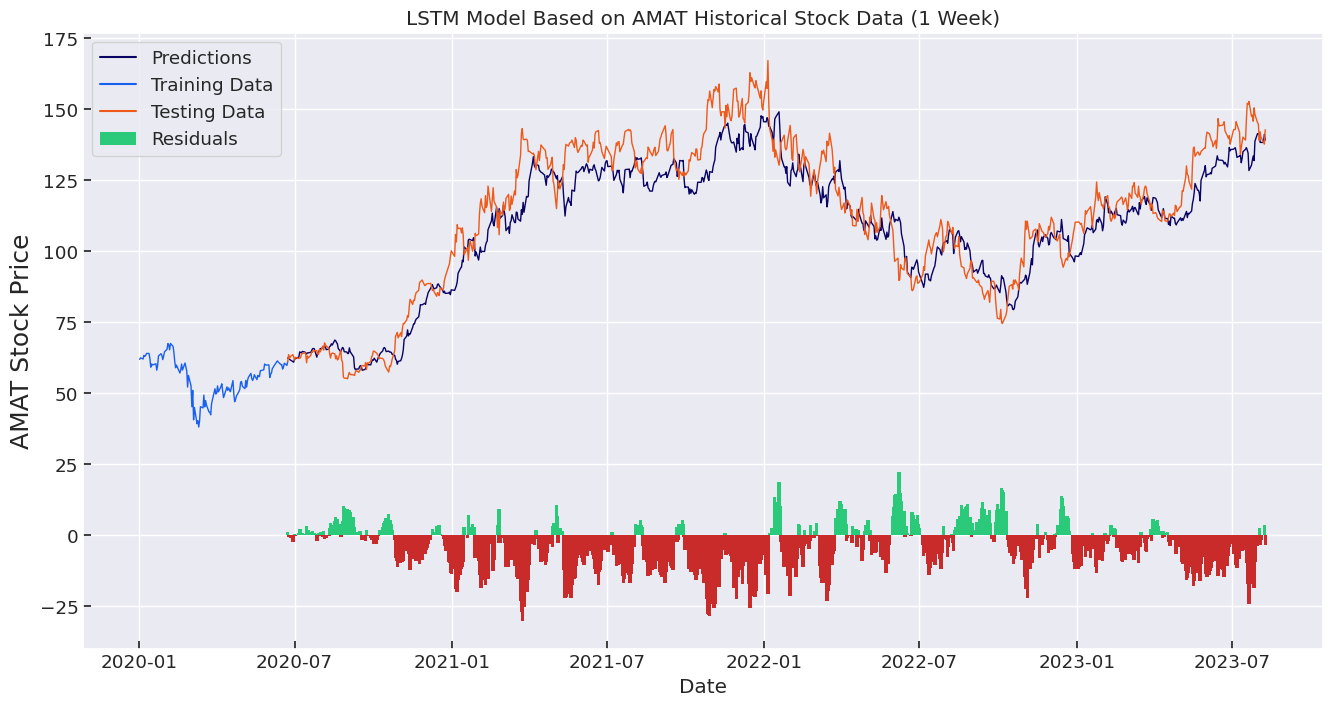

In [28]:
display_start_date = "2020-01-01"

train = pd.DataFrame(data_filtered_ext['Close Shifted'][:train_data_len + 1]).rename(columns={'Close Shifted': 'Training Data'})
valid = pd.DataFrame(data_filtered_ext['Close Shifted'][train_data_len:][:-7]).rename(columns={'Close Shifted': 'Testing Data'})
valid.insert(1, "Predictions", y_pred[:-7], True)
valid.insert(1, "Residuals", valid["Predictions"] - valid["Testing Data"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Model Based on AMAT Historical Stock Data (1 Week)")
plt.ylabel("AMAT Stock Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['Predictions', 'Training Data', 'Testing Data']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["Residuals"].dropna()]
ax1.bar(height=df_union_zoom['Residuals'].dropna(), x=df_union_zoom['Residuals'].dropna().index, width=4, label='Residuals', color=df_sub, edgecolor='none')
ax1.tick_params(which='both', direction='in', bottom=True, left=True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
plt.legend()
plt.show()

DatetimeIndex(['1992-01-27', '1992-01-28', '1992-01-29', '1992-01-30',
               '1992-01-31', '1992-02-03', '1992-02-04', '1992-02-05',
               '1992-02-06', '1992-02-07',
               ...
               '2023-07-27', '2023-07-28', '2023-07-31', '2023-08-01',
               '2023-08-02', '2023-08-03', '2023-08-04', '2023-08-07',
               '2023-08-08', '2023-08-09'],
              dtype='datetime64[ns]', name='Date', length=7944, freq=None)


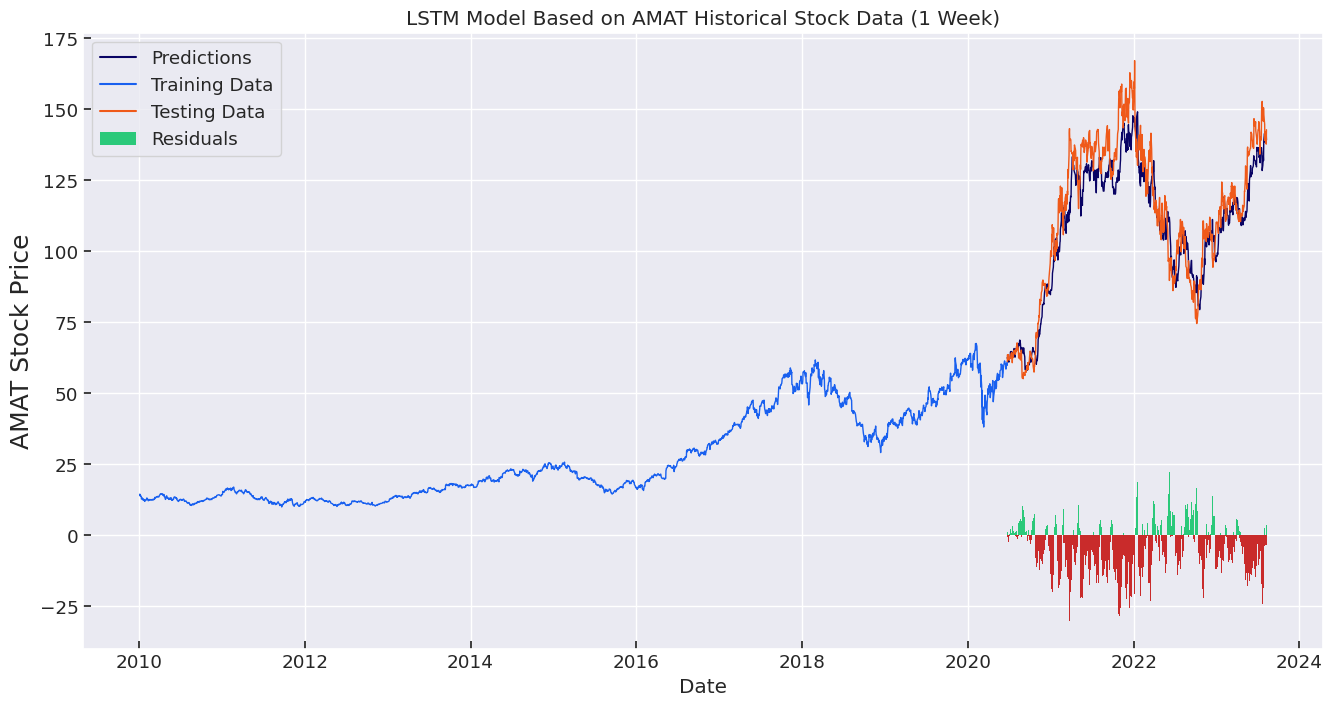

In [29]:
display_start_date = "2010-01-01"

train = pd.DataFrame(data_filtered_ext['Close Shifted'][:train_data_len + 1]).rename(columns={'Close Shifted': 'Training Data'})
valid = pd.DataFrame(data_filtered_ext['Close Shifted'][train_data_len:][:-7]).rename(columns={'Close Shifted': 'Testing Data'})
valid.insert(1, "Predictions", y_pred[:-7], True)
valid.insert(1, "Residuals", valid["Predictions"] - valid["Testing Data"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Model Based on AMAT Historical Stock Data (1 Week)")
plt.ylabel("AMAT Stock Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['Predictions', 'Training Data', 'Testing Data']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["Residuals"].dropna()]
ax1.bar(height=df_union_zoom['Residuals'].dropna(), x=df_union_zoom['Residuals'].dropna().index, width=4, label='Residuals', color=df_sub, edgecolor='none')
ax1.tick_params(which='both', direction='in', bottom=True, left=True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
plt.legend()
plt.show()